In [15]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from metrics import metrics
from sklearn.ensemble import RandomForestRegressor

# librairies perso
from make_train_test_set import make_train_test_set
from import_data import import_data
from metrics import metrics 
from group_by_clients import group_by_clients
from model import creation_model
from model_by_client import creation_model_by_client

In [2]:
data = import_data()

In [3]:
def set_up_index(index): 
    index.rename({"Date": "horodate"}, axis = 1, inplace = True)
    index["horodate"] = pd.to_datetime(index["horodate"])
    index.set_index("horodate", inplace = True)
    index = index.asfreq("D")
    index.reset_index(inplace = True)
    index = index.fillna(method = "ffill")
    date = (index["horodate"] >= pd.to_datetime("2021-01-01")) & (index["horodate"] <= pd.to_datetime("2023-01-31"))
    index = index[date]
    index.reset_index(inplace = True)
    index = index[["horodate", "Open"]]
    return index 

In [4]:
CAC = pd.read_csv("../data/^FCHI.csv")
AEX = pd.read_csv("../data/^AEX.csv")
BFX = pd.read_csv("../data/^BFX.csv")
STOXX = pd.read_csv("../data/^STOXX50E.csv")
Airliquide = pd.read_csv("../data/AI.PA.csv")
gasNat = pd.read_csv("../data/EEX.csv").rename({"Ouvert": "Open"}, axis = 1)

CAC = set_up_index(CAC)
AEX = set_up_index(AEX)
BFX = set_up_index(BFX)
STOXX = set_up_index(STOXX)
Airliquide = set_up_index(Airliquide)
gasNat = set_up_index(gasNat)

CAC.rename({"Open": "CAC"}, axis = 1, inplace = True)
AEX.rename({"Open": "AEX"}, axis = 1, inplace = True)
BFX.rename({"Open": "BFX"}, axis = 1, inplace = True)
STOXX.rename({"Open": "STOXX"}, axis = 1, inplace = True)
Airliquide.rename({"Open": "Airliquide"}, axis = 1, inplace = True)
gasNat.rename({"Open": "gasNat"}, axis = 1, inplace = True)

#CAC.rename({"Volume": "CAC"}, axis = 1, inplace = True)
#AEX.rename({"Volume": "AEX"}, axis = 1, inplace = True)
#BFX.rename({"Volume": "BFX"}, axis = 1, inplace = True)
#STOXX.rename({"Volume": "STOXX"}, axis = 1, inplace = True)

In [5]:
# il faut merge avec le tableau principal
data = pd.merge(data, CAC, on = ["horodate"], how = "left")
data = pd.merge(data, AEX, on = ["horodate"], how = "left")
data = pd.merge(data, BFX, on = ["horodate"], how = "left")
data = pd.merge(data, STOXX, on = ["horodate"], how = "left")
data = pd.merge(data, Airliquide, on = ["horodate"], how = "left")
data = pd.merge(data, gasNat, on = ["horodate"], how = "left")
n = data["id_client"].max()
test_data = data[data["horodate"] > pd.to_datetime("2022-08-31")]

In [6]:
data = data[~(data["id_client"].isin([8,9, 17, 23, 28, 38 , 49]))]

In [7]:
def creation_model(df, xarg, yarg, sep):
    train_size = int(len(df.groupby("id_client").get_group(1)) * sep)
    date = df.groupby("id_client").get_group(1)["horodate"][:train_size].iloc[-1]
    train = df[df["horodate"] <= date]
    test = df[df["horodate"] > date]
    X_train = train.copy()[xarg]
    Y_train = train.copy()[yarg]
    X_test = test.copy()[xarg]
    Y_test = test.copy()[yarg]

    # création du model
    model = LinearRegression()
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)

    comp = pd.DataFrame(Y_test.copy())
    comp["pred"] = y_pred
    comp["id_client"] = X_test["id_client"]
    evaluation_model = []

    evaluation_model = []
    for i in df["id_client"].unique():
        y = comp.groupby("id_client").get_group(i)["pred"]
        y2 = comp.groupby("id_client").get_group(i)["real_consumption"]
        evaluation_model.append(metrics(y2, y))
    return model, evaluation_model

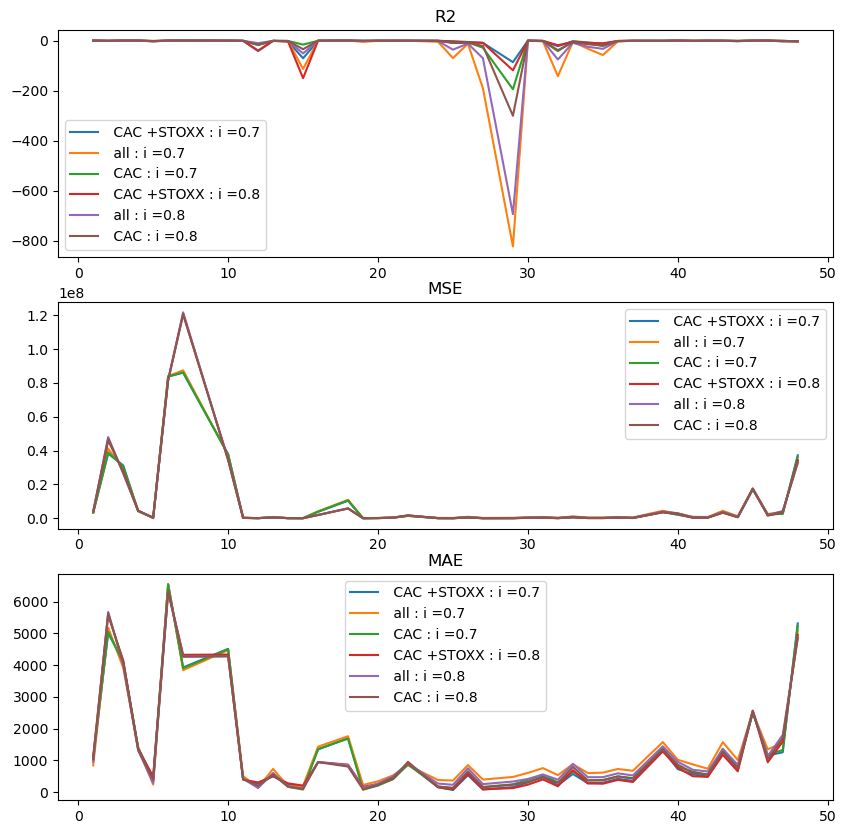

In [8]:
X = data["id_client"].unique()

evalutation_airliquide_model = []
for i in data["id_client"].unique(): 
    evalutation_airliquide_model.append(metrics(test_data.groupby("id_client").get_group(i)["real_consumption"], test_data.groupby("id_client").get_group(i)["prediction"]))

fig, ax = plt.subplots(3, figsize = (10,10))
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(7,9): 
    model, eval_model_CAX_STOXX = creation_model(data, ["id_client", "forecasted_consumption", "CAC", "STOXX"], ["real_consumption"], i/10)
    model, eval_model_all = creation_model(data, ["id_client", "forecasted_consumption", "CAC", "STOXX", "BFX", "AEX"], ["real_consumption"], i/10)
    model, eval_model_CAC = creation_model(data, ["id_client", "forecasted_consumption", "CAC"], ["real_consumption"], i/10)
    for j in range(3): 
        ax[j].plot(X, [x[j] for x in eval_model_CAX_STOXX], label = f" CAC +STOXX : i ={i/10}")
        ax[j].plot(X, [x[j] for x in eval_model_all], label = f" all : i ={i/10}")
        ax[j].plot(X, [x[j] for x in eval_model_CAC], label = f" CAC : i ={i/10}")
        ax[j].legend()

## Random Forest

In [9]:
def creation_model_rf(df, xarg, yarg, sep):
    train_size = int(len(df.groupby("id_client").get_group(1)) * sep)
    date = df.groupby("id_client").get_group(1)["horodate"][:train_size].iloc[-1]
    train = df[df["horodate"] <= date]
    test = df[df["horodate"] > date]
    X_train = train.copy()[xarg]
    Y_train = np.array(train.copy()[yarg]).ravel()
    X_test = test.copy()[xarg]
    Y_test = np.array(test.copy()[yarg]).ravel()

    # création du model
    model = RandomForestRegressor(n_estimators=150, random_state=42)
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    
    comp = pd.DataFrame(Y_test.copy(), columns = ["real_consumption"], index = X_test.index)
    comp["pred"] = y_pred
    comp["id_client"] = X_test["id_client"]
    evaluation_model = []

    
    for i in df["id_client"].unique():
        y = comp.groupby("id_client").get_group(i)["pred"]
        y2 = comp.groupby("id_client").get_group(i)["real_consumption"]
        evaluation_model.append(metrics(y2, y))
    
    return model, evaluation_model

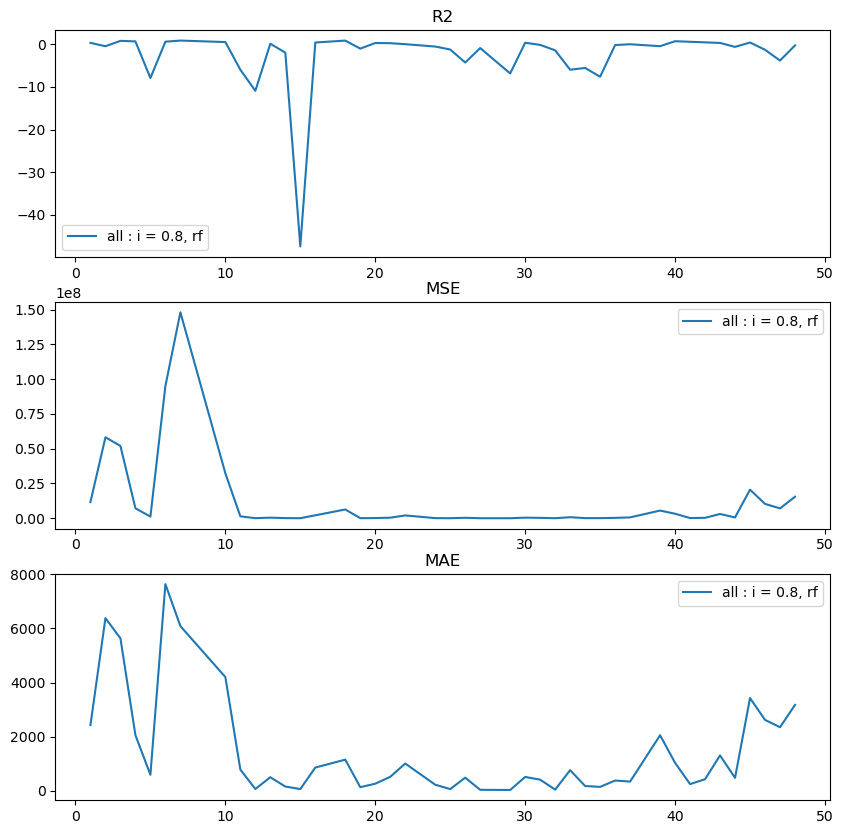

In [10]:
X = data["id_client"].unique()
evalutation_airliquide_model = []
for i in data["id_client"].unique(): 
    evalutation_airliquide_model.append(metrics(test_data.groupby("id_client").get_group(i)["real_consumption"], test_data.groupby("id_client").get_group(i)["prediction"]))

fig, ax = plt.subplots(3, figsize = (10,10))
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(8,9): 
    #model, eval_model_CAX_STOXX_rf = creation_model_rf(data, ["id_client", "forecasted_consumption", "CAC", "STOXX"], ["real_consumption"], i/10)
    model, eval_model_all_rf = creation_model_rf(data, ["id_client", "forecasted_consumption", "CAC", "STOXX"], ["real_consumption"], i/10)
    #model, eval_model_CAC_rf = creation_model_rf(data, ["id_client", "forecasted_consumption", "CAC"], ["real_consumption"], i/10)
    for j in range(3): 
        #ax[j].plot(X, [x[j] for x in eval_model_CAX_STOXX_rf], label = f" CAC +STOXX : i ={i/10}")
        ax[j].plot(X, [x[j] for x in eval_model_all_rf], label = f"all : i = {i/10}, rf")
        #ax[j].plot(X, [x[j] for x in eval_model_CAC_rf], label = f" CAC : i ={i/10}")
        ax[j].legend()

In [11]:
feature_importance = pd.DataFrame(model.feature_importances_).T
feature_importance.columns = model.feature_names_in_

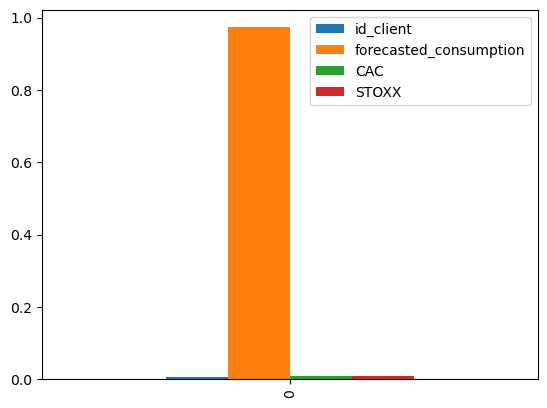

In [12]:
feature_importance.plot.bar();

In [16]:
clients = group_by_clients(data)

KeyError: 8